In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

In [4]:
raw_dataset_folder='/home/user/sample200'
# raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp43'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])

In [7]:
rawset.rebuild_categories()

In [8]:
data3 = pd.read_csv('results/exp43/evaluate.tsv', sep='\t')
data3 = data3.sort_values('not_random')
data3

,cat,not_random
11,dwf,0.394
10,swf,0.436
17,gz,0.451
4,pdf,0.495
18,ppt,0.515
27,png,0.543
24,kmz,0.554
23,pptx,0.650
25,pps,0.797
2,doc,0.846


In [37]:
data3.iloc[0,1]

0.39399999999999996

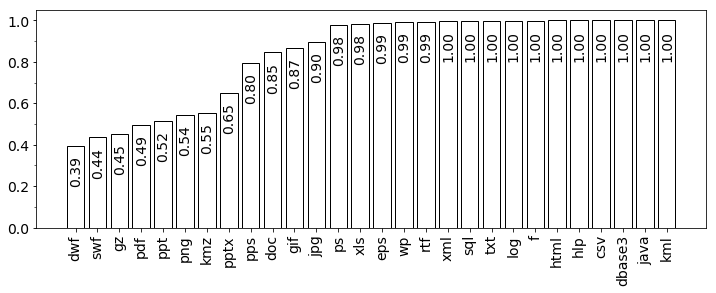

In [69]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data3.iloc[i,1]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.1),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [4]:
import itertools

In [15]:
len(list(itertools.combinations(rawset.categories, 1)))

30

In [22]:
data = pd.read_csv('results/exp31a/2019-10-04-162839/nclasses.tsv', sep='\t')
data

,n,cats,val_categorical_accuracy
0,2,"wp,hlp",0.962500
1,3,"pps,eps,text",0.823375
2,4,"text,rtf,eps,doc",0.777750
3,5,"wp,csv,gz,txt,f",0.782000
4,6,"html,wp,xls,csv,pdf,kml",0.892875
...,...,...,...
75,19,"text,dbase3,png,gif,kml,dwf,xml,pdf,f,gz,pps,h...",0.547250
76,20,"png,swf,wp,doc,f,dbase3,gif,log,ps,xml,java,jp...",0.463750
77,21,"png,text,dbase3,kml,csv,xls,unk,doc,sql,jpg,pp...",0.449500
78,22,"text,gif,png,unk,wp,csv,swf,doc,xls,kml,dwf,rt...",0.478750


In [23]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right'):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels:
        for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g+', 'r*', '.mD']):
            plt.plot(x, y, mark, label=label)
    else:
        for x, y, mark in zip(xs, ys, ['bx', 'g+', 'r*', '.mD']):
            plt.plot(x, y, mark)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')
    plt.show()

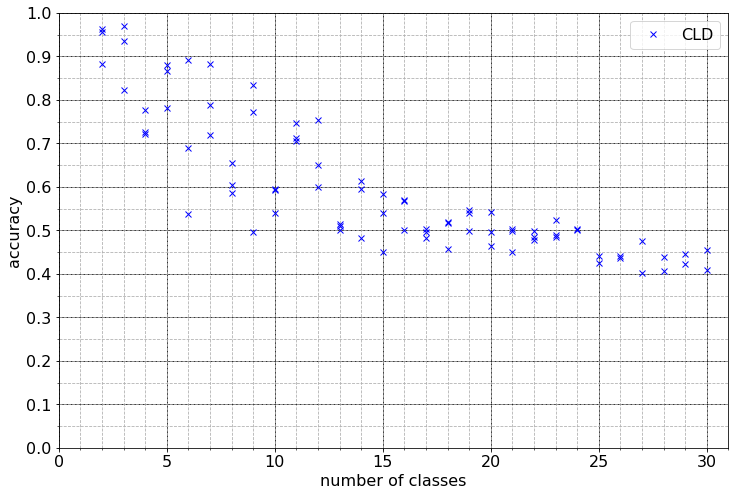

In [24]:
plot_acc([data['n']], [data['val_categorical_accuracy']], ['CLD'])

In [4]:
cat_models = {}
for cat in list(rawset.categories):
    print(cat)
    model = tensorflow.keras.models.load_model('results/exp36/%s_random.h5'%cat)
    cat_models[cat] = model

log
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
rtf
xls
txt
pps
html
dwf
png
ps
pptx
jpg
unk
csv
sql
hlp
ppt
gif
eps
f
kmz
pdf
xml
dbase3
doc
kml
text
gz
wp
java
swf


In [5]:
data = pd.read_csv('results/exp36/experiments.tsv', sep='\t')
data[:2]

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy
0,unk,19,3m48s,0.982375,0.982375
1,jpg,11,2m12s,0.531750,0.531750


In [6]:
data = data.sort_values('val_categorical_accuracy')

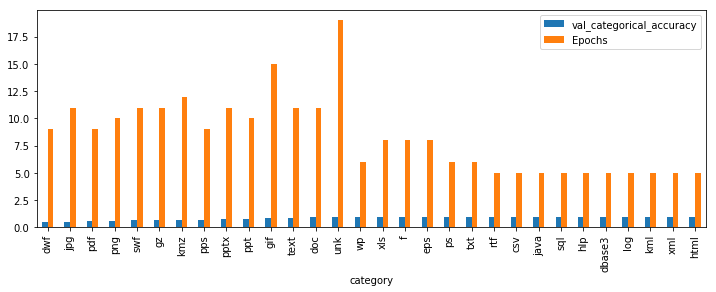

In [7]:
data.plot.bar('category', ['val_categorical_accuracy','Epochs'], figsize=(12,4))
plt.show()

In [8]:
data

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy
17,dwf,9,1m50s,0.506375,0.506375
1,jpg,11,2m12s,0.531750,0.531750
10,pdf,9,1m49s,0.590875,0.590875
21,png,10,2m03s,0.613125,0.613125
28,swf,11,2m20s,0.644000,0.644000
16,gz,11,2m14s,0.655500,0.655500
5,kmz,12,2m22s,0.669375,0.669375
25,pps,9,2m15s,0.715500,0.715500
4,pptx,11,2m22s,0.754000,0.754000
6,ppt,10,1m59s,0.813750,0.813750


In [10]:
for cat, tset, dset in datasets_X_random(raw_dset=rawset.by_category()['dwf'], rnd_dset=rndset):
    print(cat)

dwf


In [11]:
len(tset.filenames)

200

In [12]:
model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(2, 8, 'softmax', 'categorical_crossentropy')

In [18]:
result = Trainer(model,patience=30).train(tset, dset)

In [19]:
result.history.history['val_categorical_accuracy']

[0.537,
 0.547125,
 0.542125,
 0.537125,
 0.547625,
 0.566125,
 0.532125,
 0.528375,
 0.5455,
 0.531875,
 0.53875,
 0.532,
 0.526875,
 0.53875,
 0.52575,
 0.533125,
 0.52475,
 0.526,
 0.5285,
 0.528,
 0.52175,
 0.5405,
 0.53875,
 0.524625,
 0.53225,
 0.524125,
 0.523,
 0.541125,
 0.52275,
 0.53175,
 0.52125,
 0.520875,
 0.52225,
 0.520625,
 0.526,
 0.5255]

In [20]:
import matplotlib.pyplot as plt

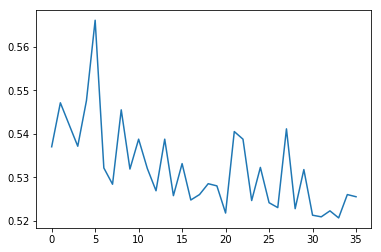

In [21]:
plt.plot(result.history.history['val_categorical_accuracy'])

In [22]:
plt.savefig('/tmp/1.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
import block_sampler

In [8]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp39'

In [11]:
rawset = block_sampler.Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [12]:
bsc = block_sampler.BlockSamplerByCategory(rawset)       

In [26]:
x = iter(bsc)
category_prob = bsc.category_prob
category_prob['ppt'] = 200
bsc.category_prob = category_prob


In [27]:
for n in range(10):
    y = next(x)
    print(y.category)

csv
ppt
ppt
rtf
ppt
ppt
ppt
ppt
ppt
ppt


In [1]:
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
import numpy as np

In [ ]:
x = np.ones((1,512,3)) * 0.01
x = tf.keras.layers.InputLayer(input_shape=(None,512,8))(x)
x

In [137]:
y =np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [1,0,0],
], dtype='float32')
y = tf.keras.layers.InputLayer(input_shape=(None,4,3), dtype='float32')(y)
y

<tf.Tensor: id=2546, shape=(4, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [152]:
K.repeat_elements(K.reshape(y, [1,4,3]), 3, 0)

<tf.Tensor: id=2597, shape=(3, 4, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]]], dtype=float32)>

TypeError: repeat_elements() missing 3 required positional arguments: 'x', 'rep', and 'axis'

In [140]:
def f(x):
    return K.sum(x, axis=1)
Reshape((1,4,3))(y)

InvalidArgumentError: Input to reshape is a tensor with 12 values, but the requested shape has 48 [Op:Reshape]

In [ ]:
    def f(att):
        w = K.sum(att, axis=1)
        w = K.repeat_elements(w, 253, 1)
        w = K.squeeze(att, 2)/w
        return att
    
    last = l0 = Input(shape=(512,len_byte_vector))

    window = 8
    strides = 2
    att = Conv1D(1, (window,), strides=strides)(last)
    att = Activation('relu')(att)
    att = Activation('tanh')(att)
    att = Lambda(f)(att)

#     att = BatchNormalization(axis=1)(att)
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

In [168]:
last

<tf.Tensor 'multiply_3/Identity:0' shape=(?, 512, 8) dtype=float32>

In [123]:
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

AttributeError: 'Tensor' object has no attribute 'conjugate'

In [88]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape
import tensorflow.keras.backend as K

In [50]:
len_byte_vector = 8

In [119]:
    last = l0 = Input(shape=(512,len_byte_vector))

    window = 8
    strides = 2
    att = Conv1D(1, (window,), strides=strides)(last)
    att = Activation('relu')(att)
    att = Activation('tanh')(att)
    att = 

<tf.Tensor 'activation_53/Identity:0' shape=(?, 253, 1) dtype=float32>

In [99]:
#     att = BatchNormalization(axis=1)(att)
    att = Lambda(lambda y:tf.keras.utils.normalize(y, axis = 0))
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

In [100]:
att

<tf.Tensor 'multiply_1/Identity:0' shape=(?, 512, 8) dtype=float32>

In [59]:
att

<tf.Tensor 'activation_9/Identity:0' shape=(?, 505, 1) dtype=float32>

In [45]:
mask = np.zeros((att.shape[-2],512))
for x in range(mask.shape[0]):
    mask[x,x*strides:x*strides+window]=1
mask.shape

(253, 512)

In [46]:
mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [19]:
for x in range(mask.shape[0]):
    mask[x,x:x+8]=1
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [11]:
z = tf.keras.layers.RepeatVector(3)(y)
z = tf.keras.layers.Permute([2,1])(z)
z = tf.keras.layers.Flatten()(z)
z

<tf.Tensor: id=46, shape=(1, 12), dtype=float64, numpy=array([[0., 0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3.]])>

In [49]:
z = tf.keras.layers.Permute([2,1])(z)
z

<tf.Tensor: id=152, shape=(1, 512, 3), dtype=float64, numpy=
array([[[  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  2.,   2.,   2.],
        ...,
        [509., 509., 509.],
        [510., 510., 510.],
        [511., 511., 511.]]])>

In [50]:
tf.keras.layers.Multiply()([x,z])

<tf.Tensor: id=154, shape=(1, 512, 3), dtype=float64, numpy=
array([[[0.  , 0.  , 0.  ],
        [0.01, 0.01, 0.01],
        [0.02, 0.02, 0.02],
        ...,
        [5.09, 5.09, 5.09],
        [5.1 , 5.1 , 5.1 ],
        [5.11, 5.11, 5.11]]])>